<div align="center">

<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2024/01/logo_telecom_ipparis_rvb_fond_h.png" alt="Telecom Paris Logo" width="300"/>

---

# **Projet Big Data - EDA**
## *IADATA700 - Kit Big Data*

# 🍂 Analyse statistique / Recettes / Saisonnalité

In [10]:
import sys
sys.path.append('../../')

# Forcer le rechargement de notre module
from _data_utils import *

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings

from scipy import stats
from scipy.stats import spearmanr, kendalltau, kruskal, chi2_contingency, chisquare, kstest
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

warnings.filterwarnings('ignore')

# Configuration graphique
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Import réussi !")

✅ Import réussi !


## 📥 Chargement des données

In [11]:
# 🚀 Pipeline complet : charge + nettoie + enrichit
df = load_clean_recipes()

print(f"✅ Dataset prêt : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
print(f"📅 Période : {df['year'].min()} - {df['year'].max()}")

# 📊 Rapport de qualité
report = analyze_recipe_quality(df)

1️⃣ Chargement des données brutes...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✅ Recettes chargées depuis S3 : 231,637 lignes × 12 colonnes

2️⃣ Nettoyage des données...
🧹 Nettoyage des recettes...
   ✓ 18,482 recettes avec minutes invalides (<1 ou >180)
   ℹ️  Seuils calculés (IQ 90% = Q5%-Q95%):
      • n_steps: [2, 24] (médiane=9, moyenne=9.7)
      • n_ingredients: [3, 17] (médiane=9, moyenne=9.0)
   ✓ 13,088 recettes avec n_steps ou n_ingredients aberrants (hors IQ 90%)
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1999 - 2018
📊 Analyse de qualité des données...
✅ Nettoyage terminé : 200,066 recettes conservées (31,571 supprimées)

3️⃣ Enrichissement des features...
⚙️ Enrichissement des recettes...
✅ Enrichissement terminé : 28 colonnes totales

✅ Pipeline complet terminé !
✅ Dataset prêt : 200,066 lignes × 28 colonnes
📅 Période : 1

## Analyse statistique

### Analyse 1 : Évolution du volume de recettes
#### Visualisation

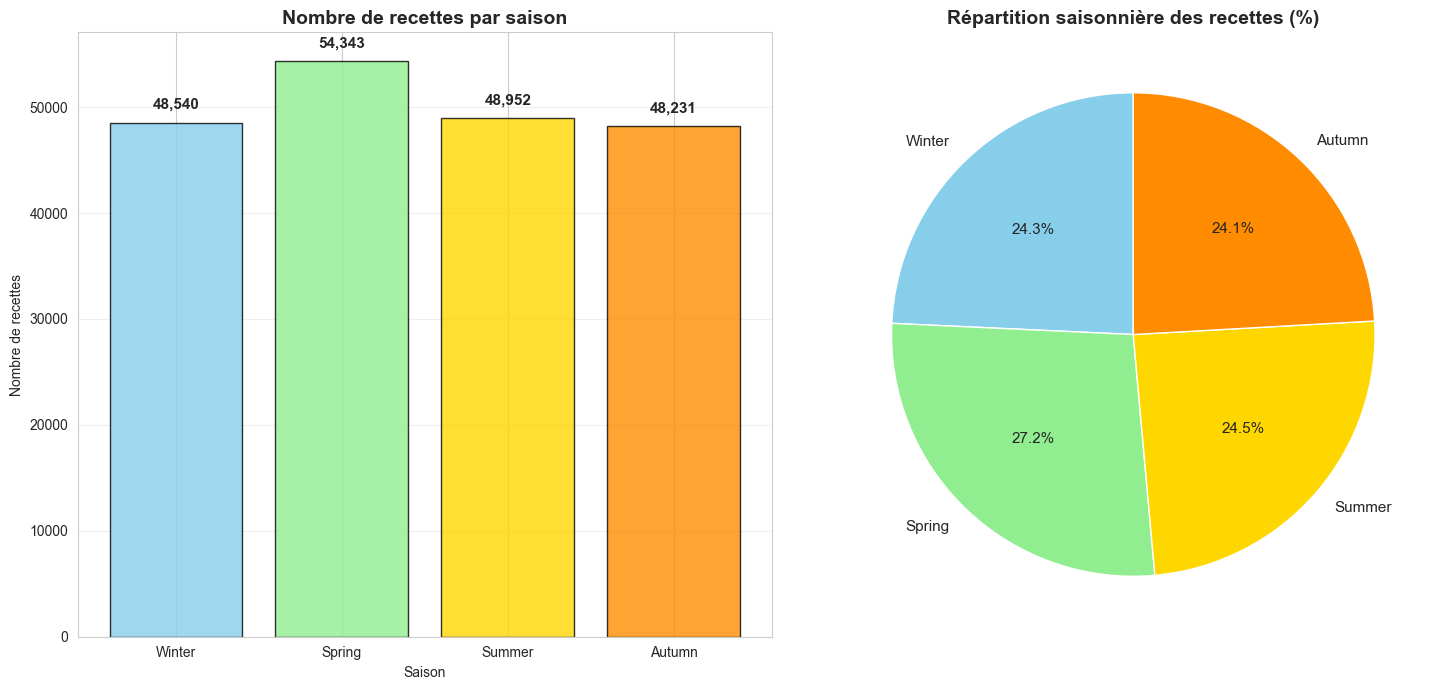

In [13]:
recipes_per_season = (df.group_by("season").agg(pl.len().alias("n_recipes")).sort("season").to_pandas())

# Visualization
season_order = ["Winter", "Spring", "Summer", "Autumn"]
season_colors = {"Winter": "#87CEEB", "Spring": "#90EE90", "Summer": "#FFD700", "Autumn": "#FF8C00"}
recipes_per_season = recipes_per_season.set_index('season').loc[season_order].reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

colors = [season_colors[season] for season in recipes_per_season['season']]
bars = ax1.bar(recipes_per_season['season'], recipes_per_season['n_recipes'], 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Nombre de recettes par saison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Saison')
ax1.set_ylabel('Nombre de recettes')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, recipes_per_season['n_recipes']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

sizes = recipes_per_season['n_recipes']
labels = recipes_per_season['season']
colors_pie = [season_colors[season] for season in recipes_per_season['season']]
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 11})
ax2.set_title('Répartition saisonnière des recettes (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Tests statistiques

In [14]:
observed = recipes_per_season['n_recipes'].values
expected_uniform = [recipes_per_season['n_recipes'].sum() / 4] * 4

chi2_stat, chi2_p = chisquare(observed, expected_uniform)
print(f"Test Chi-2 (uniformité): χ² = {chi2_stat:.4f} (p = {chi2_p:.6f})")
print(f"Répartition uniforme: {'❌ Rejetée' if chi2_p < 0.05 else '✅ Acceptée'}")

mean_recipes = recipes_per_season['n_recipes'].mean()
std_recipes = recipes_per_season['n_recipes'].std()
cv = (std_recipes / mean_recipes) * 100

print(f"\nVariabilité saisonnière:")
print(f"   • Moyenne: {mean_recipes:.0f} recettes/saison")
print(f"   • Écart-type: {std_recipes:.0f} recettes")
print(f"   • Coefficient de variation: {cv:.1f}%")

print(f"\n🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:")
print("-" * 50)

for _, row in recipes_per_season.iterrows():
    season_fr = row['season']
    count = int(row['n_recipes'])
    deviation = count - mean_recipes
    deviation_pct = (deviation / mean_recipes) * 100
    status = "📈" if deviation > 0 else "📉" if deviation < -std_recipes else "➡️"
    print(f"{status} {season_fr:>12}: {count:>7,} ({deviation:+6.0f}, {deviation_pct:+5.1f}%)")


Test Chi-2 (uniformité): χ² = 504.2301 (p = 0.000000)
Répartition uniforme: ❌ Rejetée

Variabilité saisonnière:
   • Moyenne: 50016 recettes/saison
   • Écart-type: 2899 recettes
   • Coefficient de variation: 5.8%

🔍 ÉCARTS PAR RAPPORT À LA MOYENNE:
--------------------------------------------------
➡️       Winter:  48,540 ( -1476,  -3.0%)
📈       Spring:  54,343 ( +4326,  +8.7%)
➡️       Summer:  48,952 ( -1064,  -2.1%)
➡️       Autumn:  48,231 ( -1786,  -3.6%)


#### Interprétation

> **💡 Interprétation:** 
>  
> Le **test du χ²** montre que la **répartition saisonnière** du nombre de recettes **n’est pas uniforme**, avec des **écarts significatifs** entre les saisons.  
>
> Le **printemps**, nettement au-dessus de la moyenne, indique une **saisonnalité marquée** dans la production, tandis que les autres saisons restent **relativement stables**.  
>

### Analyse 2: Évolution de la durée moyenne
#### Visualisation

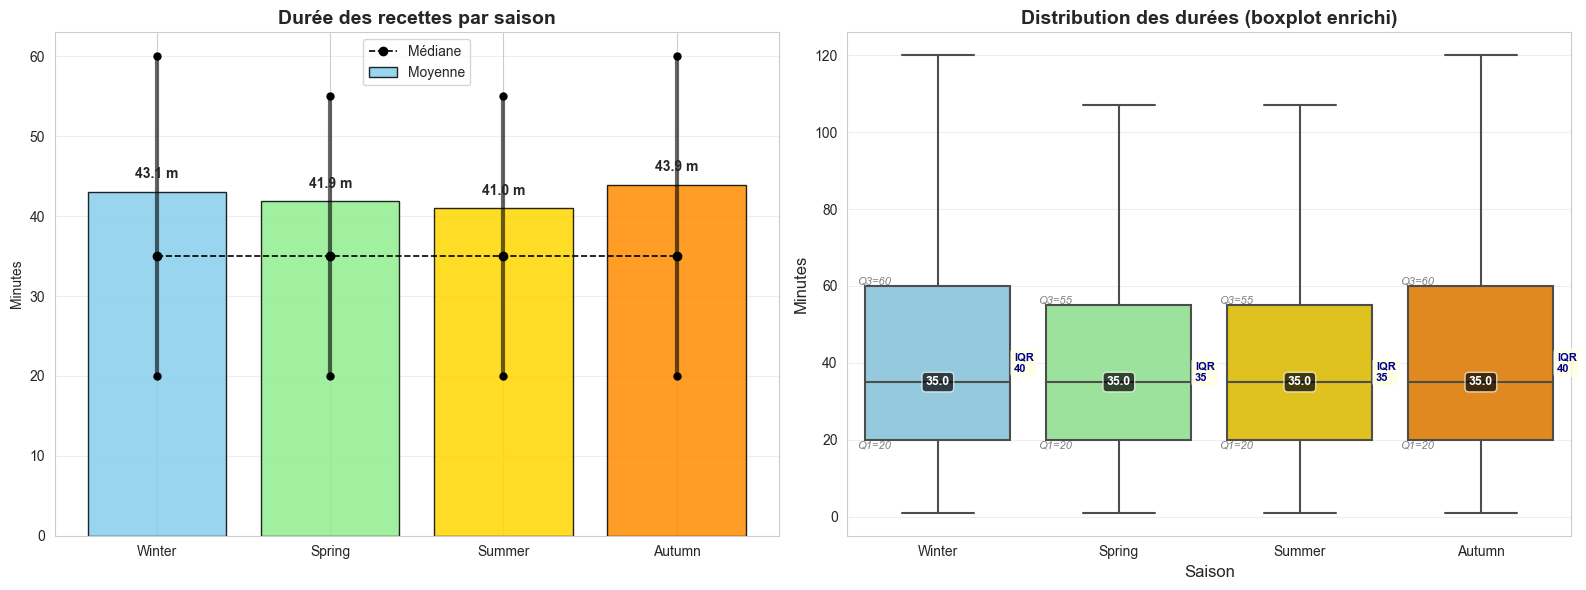

In [15]:
minutes_by_season = (df.group_by("season")
    .agg([
        pl.mean("minutes").alias("mean_minutes"), 
        pl.median("minutes").alias("median_minutes"),
        pl.quantile("minutes",0.25).alias("q25"), 
        pl.quantile("minutes",0.75).alias("q75"), 
        pl.len().alias("n_recipes")
    ]).sort("season").to_pandas().set_index("season").loc[season_order].reset_index())
minutes_by_season["IQR"] = minutes_by_season["q75"] - minutes_by_season["q25"]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
bar_colors=[season_colors[s] for s in minutes_by_season.season]

# --- GRAPHIQUE 1 : Barres + Médiane + IQR ---
ax1.bar(minutes_by_season.season, minutes_by_season.mean_minutes, 
        color=bar_colors, alpha=.85, edgecolor='black', lw=1, label='Moyenne')
ax1.plot(minutes_by_season.season, minutes_by_season.median_minutes, 
         'o--', color='black', lw=1.2, ms=6, label='Médiane')
for s,m,med,q25,q75,_n,_iqr in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','n_recipes','IQR']].itertuples(index=False):
    ax1.vlines(s,q25,q75,color='black',lw=3,alpha=.6)
    ax1.scatter([s],[q25],color='black',s=25)
    ax1.scatter([s],[q75],color='black',s=25)
    ax1.text(s,m*1.03,f"{m:.1f} m",ha='center',va='bottom',fontsize=10,fontweight='bold')
ax1.set_title("Durée des recettes par saison",fontsize=14,fontweight='bold')
ax1.set_ylabel("Minutes")
ax1.grid(axis='y',alpha=.3)
ax1.legend()

# --- GRAPHIQUE 2 : Boxplot enrichi ---
bp = sns.boxplot(data=df.to_pandas(), x='season', y='minutes', order=season_order,
                 palette=[season_colors[s] for s in season_order], ax=ax2, 
                 showfliers=False, linewidth=1.5)

# Annotations : médiane, Q1, Q3, IQR sur chaque boîte
for i, season in enumerate(season_order):
    season_data = minutes_by_season[minutes_by_season['season'] == season].iloc[0]
    median = season_data['median_minutes']
    q25 = season_data['q25']
    q75 = season_data['q75']
    iqr = season_data['IQR']
    
    # Médiane (ligne centrale)
    ax2.text(i, median, f'{median:.1f}', 
             ha='center', va='center', fontsize=9, fontweight='bold', 
             color='white', bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    
    # Q1 (bas de la boîte)
    ax2.text(i-0.35, q25, f'Q1={q25:.0f}', 
             ha='center', va='top', fontsize=8, color='gray', style='italic')
    
    # Q3 (haut de la boîte)
    ax2.text(i-0.35, q75, f'Q3={q75:.0f}', 
             ha='center', va='bottom', fontsize=8, color='gray', style='italic')
    
    # IQR (à côté de la boîte)
    ax2.text(i+0.42, (q25+q75)/2, f'IQR\n{iqr:.0f}', 
             ha='left', va='center', fontsize=8, color='darkblue', fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.25', facecolor='lightyellow', alpha=0.8))

ax2.set_title("Distribution des durées (boxplot enrichi)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Saison", fontsize=12)
ax2.set_ylabel("Minutes", fontsize=12)
ax2.grid(axis='y', alpha=.3)

plt.tight_layout()
plt.show()

#### Tests statistiques

In [16]:
# Résumé + Test Kruskal 
print("\nRésumé statistique par saison (minutes):\n" + "-"*55)
for s,m,med,q25,q75,iqr,n in minutes_by_season[['season','mean_minutes','median_minutes','q25','q75','IQR','n_recipes']].itertuples(index=False):
    print(f"{s:<8} | Moy:{m:6.1f} | Med:{med:6.1f} | Q25:{q25:6.1f} | Q75:{q75:6.1f} | IQR:{iqr:6.1f} | n={n:,}")
    
kw_stat, kw_p = kruskal(*[df.to_pandas().query('season==@s')['minutes'].values for s in season_order])
print(f"\nKruskal-Wallis: H={kw_stat:.3f}, p={kw_p:.6f}")
print(f"Différences significatives" if kw_p<0.05 else "Pas de différence nette")


Résumé statistique par saison (minutes):
-------------------------------------------------------
Winter   | Moy:  43.1 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,540
Spring   | Moy:  41.9 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=54,343
Summer   | Moy:  41.0 | Med:  35.0 | Q25:  20.0 | Q75:  55.0 | IQR:  35.0 | n=48,952
Autumn   | Moy:  43.9 | Med:  35.0 | Q25:  20.0 | Q75:  60.0 | IQR:  40.0 | n=48,231

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives

Kruskal-Wallis: H=346.926, p=0.000000
Différences significatives


#### Interprétation

> **💡 Interprétation :**  
> 
> Le **test de Kruskal-Wallis** (H = 346.93, p < 0.001) confirme des **différences significatives** de durée entre les saisons.  
> 
> Les recettes postées en **automne** et en **hiver** sont **plus longues** que celles partagées en **été**, avec une durée moyenne de **43,9 minutes** en **automne** et **43,1 minutes** en **hiver**, contre **41,0 minutes** en **été** et **41,9 minutes** au **printemps**.
> 

### Analyse 3: Évolution de la complexité
#### Visualisation

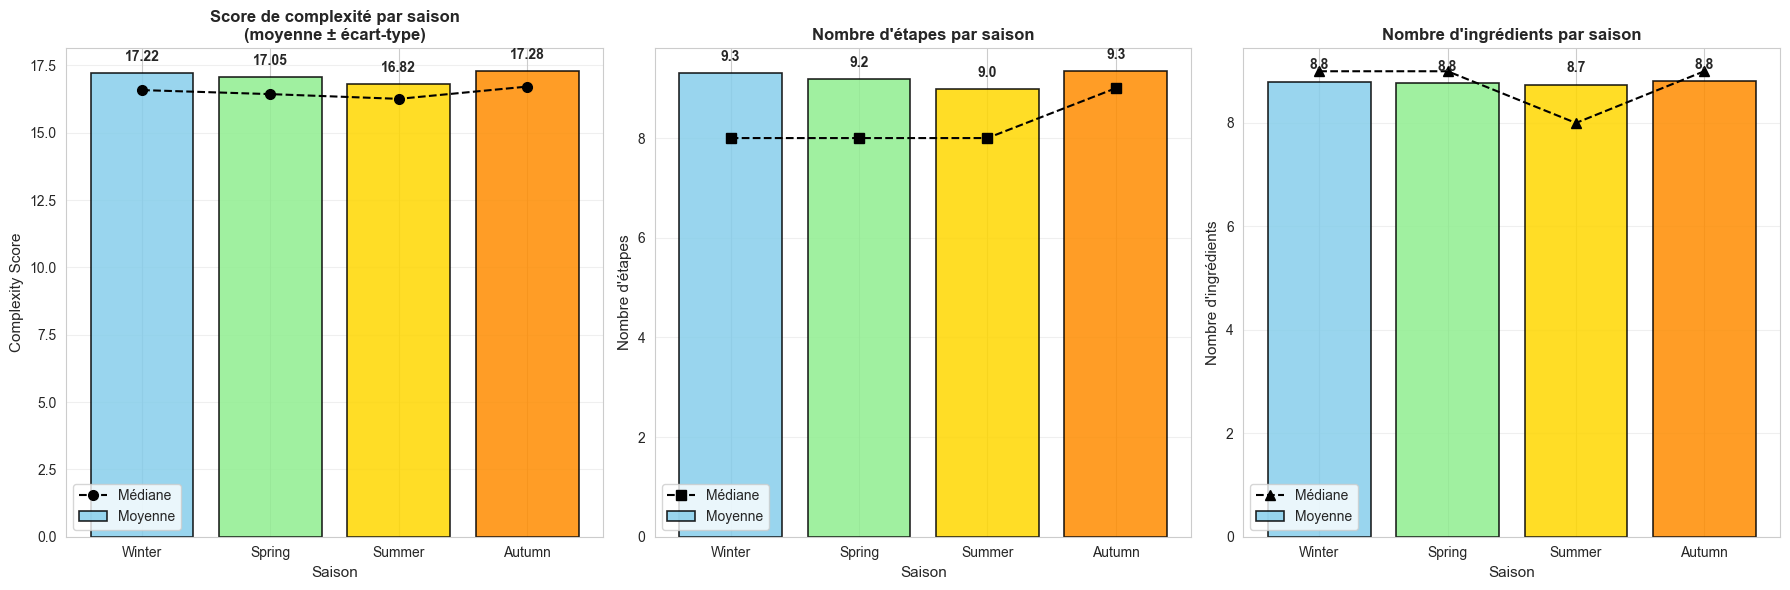

In [19]:
# 📊 Agrégation des données de complexité par saison
complexity_by_season = (
    df.group_by("season")
    .agg([
        pl.mean("complexity_score").alias("mean_complexity"),
        pl.median("complexity_score").alias("median_complexity"),
        pl.std("complexity_score").alias("std_complexity"),
        pl.mean("n_steps").alias("mean_steps"),
        pl.median("n_steps").alias("median_steps"),
        pl.mean("n_ingredients").alias("mean_ingredients"),
        pl.median("n_ingredients").alias("median_ingredients"),
        pl.quantile("complexity_score", 0.25).alias("q25_complexity"),
        pl.quantile("complexity_score", 0.75).alias("q75_complexity"),
        pl.count("id").alias("count_recipes")
    ])
    .sort("season").to_pandas()
    .set_index("season").loc[season_order].reset_index()
)

# Configuration des couleurs saisonnières
colors_dict = {s: season_colors[s] for s in season_order}

# --- VISUALISATION EN 3 PANELS ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- GRAPHIQUE 1 : Score de complexité (barres + médiane + IQR) ---
ax1 = axes[0]
bar_colors = [colors_dict[s] for s in complexity_by_season['season']]

bars = ax1.bar(complexity_by_season['season'], complexity_by_season['mean_complexity'],
               color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
               label='Moyenne')

# Médiane en ligne pointillée
ax1.plot(complexity_by_season['season'], complexity_by_season['median_complexity'],
         'o--', color='black', linewidth=1.5, markersize=7, label='Médiane')

# Barres d'erreur (std)
for i, row in complexity_by_season.iterrows():    
    # Annotations des valeurs
    ax1.text(i, row['mean_complexity'] * 1.02,
             f"{row['mean_complexity']:.2f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Score de complexité par saison\n(moyenne ± écart-type)',
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Saison', fontsize=11)
ax1.set_ylabel('Complexity Score', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='best')

# --- GRAPHIQUE 2 : Nombre d'étapes ---
ax2 = axes[1]
bars2 = ax2.bar(complexity_by_season['season'], complexity_by_season['mean_steps'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax2.plot(complexity_by_season['season'], complexity_by_season['median_steps'],
         's--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in complexity_by_season.iterrows():
    ax2.text(i, row['mean_steps'] * 1.02,
             f"{row['mean_steps']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_title('Nombre d\'étapes par saison',
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Saison', fontsize=11)
ax2.set_ylabel('Nombre d\'étapes', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(loc='best')

# --- GRAPHIQUE 3 : Nombre d'ingrédients ---
ax3 = axes[2]
bars3 = ax3.bar(complexity_by_season['season'], complexity_by_season['mean_ingredients'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax3.plot(complexity_by_season['season'], complexity_by_season['median_ingredients'],
         '^--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in complexity_by_season.iterrows():
    ax3.text(i, row['mean_ingredients'] * 1.02,
             f"{row['mean_ingredients']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_title('Nombre d\'ingrédients par saison',
              fontsize=12, fontweight='bold')
ax3.set_xlabel('Saison', fontsize=11)
ax3.set_ylabel('Nombre d\'ingrédients', fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='best')

plt.tight_layout()
plt.show()

#### Tests statistiques

In [20]:
# 📊 TESTS STATISTIQUES DE COMPLEXITÉ PAR SAISON
print("=" * 80)
print("📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ PAR SAISON")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON")
print("-" * 80)
print(f"{'Saison':<10} | {'Moy Cpx':<8} | {'Med Cpx':<8} | {'Std':<8} | {'Steps':<7} | {'Ingr.':<7} | {'n':<8}")
print("-" * 80)
for _, row in complexity_by_season.iterrows():
    print(f"{row['season']:<10} | {row['mean_complexity']:>8.3f} | {row['median_complexity']:>8.3f} | "
          f"{row['std_complexity']:>8.3f} | {row['mean_steps']:>7.2f} | "
          f"{row['mean_ingredients']:>7.2f} | {row['count_recipes']:>8,}")

# --- 2. TEST DE KRUSKAL-WALLIS (complexité) ---
print("\n2️⃣ TEST DE KRUSKAL-WALLIS : Complexity Score")
print("-" * 80)
groups_complexity = [df.to_pandas().query('season==@s')['complexity_score'].values 
                     for s in season_order]
kw_stat_cpx, kw_p_cpx = kruskal(*groups_complexity)
print(f"Statistique H   : {kw_stat_cpx:.4f}")
print(f"p-value         : {kw_p_cpx:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_cpx < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 3. TEST DE KRUSKAL-WALLIS (n_steps) ---
print("\n3️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'étapes")
print("-" * 80)
groups_steps = [df.to_pandas().query('season==@s')['n_steps'].values 
                for s in season_order]
kw_stat_steps, kw_p_steps = kruskal(*groups_steps)
print(f"Statistique H   : {kw_stat_steps:.4f}")
print(f"p-value         : {kw_p_steps:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_steps < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 4. TEST DE KRUSKAL-WALLIS (n_ingredients) ---
print("\n4️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'ingrédients")
print("-" * 80)
groups_ingr = [df.to_pandas().query('season==@s')['n_ingredients'].values 
               for s in season_order]
kw_stat_ingr, kw_p_ingr = kruskal(*groups_ingr)
print(f"Statistique H   : {kw_stat_ingr:.4f}")
print(f"p-value         : {kw_p_ingr:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_ingr < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 5. COMPARAISONS POST-HOC (si Kruskal significatif) ---
if kw_p_cpx < 0.05:
    from scipy.stats import mannwhitneyu
    print("\n5️⃣ TESTS POST-HOC (Mann-Whitney U) : Complexity Score")
    print("-" * 80)
    print(f"{'Comparaison':<25} | {'U-stat':<10} | {'p-value':<12} | {'Signif.'}")
    print("-" * 80)
    
    for i, season1 in enumerate(season_order):
        for season2 in season_order[i+1:]:
            group1 = df.to_pandas().query('season==@season1')['complexity_score'].values
            group2 = df.to_pandas().query('season==@season2')['complexity_score'].values
            u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
            signif = "✅" if p_val < 0.05/6 else "➖"  # Correction de Bonferroni: 0.05/6
            print(f"{season1} vs {season2:<15} | {u_stat:>10.0f} | {p_val:>12.6e} | {signif}")

# --- 6. VARIABILITÉ SAISONNIÈRE ---
print("\n6️⃣ VARIABILITÉ SAISONNIÈRE")
print("-" * 80)
mean_cpx = complexity_by_season['mean_complexity'].mean()
std_cpx = complexity_by_season['mean_complexity'].std()
cv_cpx = (std_cpx / mean_cpx) * 100

print(f"Moyenne globale (complexité)  : {mean_cpx:.4f}")
print(f"Écart-type inter-saisons      : {std_cpx:.4f}")
print(f"Coefficient de variation      : {cv_cpx:.2f}%")

print("\n📊 ÉCARTS PAR RAPPORT À LA MOYENNE :")
print("-" * 80)
for _, row in complexity_by_season.iterrows():
    deviation = row['mean_complexity'] - mean_cpx
    deviation_pct = (deviation / mean_cpx) * 100
    status = "📈" if deviation > std_cpx else "📉" if deviation < -std_cpx else "➡️"
    print(f"{status} {row['season']:<10} : {row['mean_complexity']:.4f} "
          f"({deviation:+.4f}, {deviation_pct:+.2f}%)")

print("\n" + "=" * 80)

📊 ANALYSE STATISTIQUE DE LA COMPLEXITÉ PAR SAISON

1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON
--------------------------------------------------------------------------------
Saison     | Moy Cpx  | Med Cpx  | Std      | Steps   | Ingr.   | n       
--------------------------------------------------------------------------------
Winter     |   17.223 |   16.584 |    5.943 |    9.30 |    8.80 |   48,540
Spring     |   17.052 |   16.434 |    5.926 |    9.18 |    8.77 |   54,343
Summer     |   16.821 |   16.258 |    5.876 |    8.99 |    8.74 |   48,952
Autumn     |   17.283 |   16.714 |    5.926 |    9.34 |    8.81 |   48,231

2️⃣ TEST DE KRUSKAL-WALLIS : Complexity Score
--------------------------------------------------------------------------------
Statistique H   : 173.3569
p-value         : 2.398360e-37
Conclusion      : ✅ Différences significatives (α=0.05)

3️⃣ TEST DE KRUSKAL-WALLIS : Nombre d'étapes
--------------------------------------------------------------------------------
Statistiq

#### Interprétation

> **💡 Interprétation :**  
> 
> Les **tests de Kruskal-Wallis** révèlent des **différences significatives** de complexité entre les saisons (p < 0.001).  
> 
> Les recettes d'**hiver** et d'**automne** sont plus élaborées (plus d'étapes et d'ingrédients), tandis que l'**été** privilégie des préparations simplifiées. Cette **saisonnalité marquée** reflète les habitudes culinaires : plats mijotés en saison froide vs. recettes rapides et fraîches en période estivale.

### Analyse 4: Évolution nutritionnelle
#### Visualisation

In [ ]:
# 📊 Agrégation des données nutritionnelles par saison
nutrition_by_season = (
    df.group_by("season")
    .agg([
        pl.mean("calories").alias("mean_calories"),
        pl.median("calories").alias("median_calories"),
        pl.std("calories").alias("std_calories"),
        pl.mean("total_fat").alias("mean_fat"),
        pl.median("total_fat").alias("median_fat"),
        pl.mean("sugar").alias("mean_sugar"),
        pl.median("sugar").alias("median_sugar"),
        pl.mean("sodium").alias("mean_sodium"),
        pl.median("sodium").alias("median_sodium"),
        pl.mean("protein").alias("mean_protein"),
        pl.median("protein").alias("median_protein"),
        pl.mean("sat_fat").alias("mean_sat_fat"),
        pl.median("sat_fat").alias("median_sat_fat"),
        pl.count("id").alias("count_recipes")
    ])
    .sort("season")
)

# Conversion en pandas et réordonnancement
nutrition_by_season = (
    nutrition_by_season.to_pandas()
    .set_index("season")
    .loc[season_order]
    .reset_index()
)

# Calcul IC 95% pour calories
nutrition_by_season['ci_95_cal'] = nutrition_by_season.apply(
    lambda row: calculate_ci_width(row['std_calories'], row['count_recipes']),
    axis=1
)

# Configuration des couleurs
colors_dict = {s: season_colors[s] for s in season_order}

# --- VISUALISATION EN 3x2 PANELS ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# --- GRAPHIQUE 1 : Calories ---
ax1 = axes[0, 0]
bar_colors = [colors_dict[s] for s in nutrition_by_season['season']]

bars = ax1.bar(nutrition_by_season['season'], nutrition_by_season['mean_calories'],
               color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
               label='Moyenne')

ax1.plot(nutrition_by_season['season'], nutrition_by_season['median_calories'],
         'o--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax1.errorbar(row['season'], row['mean_calories'],
                yerr=row['ci_95_cal'], fmt='none',
                ecolor='darkred', capsize=5, capthick=2, alpha=0.7)
    ax1.text(i, row['mean_calories'] * 1.02,
             f"{row['mean_calories']:.0f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_title('Calories par saison (kcal)\n(moyenne ± IC 95%)',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Calories (kcal)', fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='best')

# --- GRAPHIQUE 2 : Lipides totaux ---
ax2 = axes[0, 1]
bars2 = ax2.bar(nutrition_by_season['season'], nutrition_by_season['mean_fat'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax2.plot(nutrition_by_season['season'], nutrition_by_season['median_fat'],
         's--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax2.text(i, row['mean_fat'] * 1.02,
             f"{row['mean_fat']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_title('Lipides totaux par saison (g)',
              fontsize=12, fontweight='bold')
ax2.set_ylabel('Lipides (g)', fontsize=11)
ax2.grid(axis='y', alpha=0.3)
ax2.legend(loc='best')

# --- GRAPHIQUE 3 : Sucre ---
ax3 = axes[0, 2]
bars3 = ax3.bar(nutrition_by_season['season'], nutrition_by_season['mean_sugar'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax3.plot(nutrition_by_season['season'], nutrition_by_season['median_sugar'],
         '^--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax3.text(i, row['mean_sugar'] * 1.02,
             f"{row['mean_sugar']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax3.set_title('Sucre par saison (g)',
              fontsize=12, fontweight='bold')
ax3.set_ylabel('Sucre (g)', fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='best')

# --- GRAPHIQUE 4 : Sodium ---
ax4 = axes[1, 0]
bars4 = ax4.bar(nutrition_by_season['season'], nutrition_by_season['mean_sodium'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax4.plot(nutrition_by_season['season'], nutrition_by_season['median_sodium'],
         'd--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax4.text(i, row['mean_sodium'] * 1.02,
             f"{row['mean_sodium']:.0f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax4.set_title('Sodium par saison (mg)',
              fontsize=12, fontweight='bold')
ax4.set_xlabel('Saison', fontsize=11)
ax4.set_ylabel('Sodium (mg)', fontsize=11)
ax4.grid(axis='y', alpha=0.3)
ax4.legend(loc='best')

# --- GRAPHIQUE 5 : Protéines ---
ax5 = axes[1, 1]
bars5 = ax5.bar(nutrition_by_season['season'], nutrition_by_season['mean_protein'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax5.plot(nutrition_by_season['season'], nutrition_by_season['median_protein'],
         'p--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax5.text(i, row['mean_protein'] * 1.02,
             f"{row['mean_protein']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax5.set_title('Protéines par saison (g)',
              fontsize=12, fontweight='bold')
ax5.set_xlabel('Saison', fontsize=11)
ax5.set_ylabel('Protéines (g)', fontsize=11)
ax5.grid(axis='y', alpha=0.3)
ax5.legend(loc='best')

# --- GRAPHIQUE 6 : Graisses saturées ---
ax6 = axes[1, 2]
bars6 = ax6.bar(nutrition_by_season['season'], nutrition_by_season['mean_sat_fat'],
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2,
                label='Moyenne')

ax6.plot(nutrition_by_season['season'], nutrition_by_season['median_sat_fat'],
         'h--', color='black', linewidth=1.5, markersize=7, label='Médiane')

for i, row in nutrition_by_season.iterrows():
    ax6.text(i, row['mean_sat_fat'] * 1.02,
             f"{row['mean_sat_fat']:.1f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')

ax6.set_title('Graisses saturées par saison (g)',
              fontsize=12, fontweight='bold')
ax6.set_xlabel('Saison', fontsize=11)
ax6.set_ylabel('Graisses saturées (g)', fontsize=11)
ax6.grid(axis='y', alpha=0.3)
ax6.legend(loc='best')

plt.tight_layout()
plt.show()

# --- HEATMAP NUTRITIONNELLE ---
fig, ax = plt.subplots(figsize=(10, 6))

# Normalisation des valeurs pour comparaison
nutrition_matrix = nutrition_by_season[['season', 'mean_calories', 'mean_fat', 
                                         'mean_sugar', 'mean_sodium', 
                                         'mean_protein', 'mean_sat_fat']].set_index('season')

# Normalisation par z-score pour chaque nutriment
from scipy.stats import zscore
nutrition_norm = nutrition_matrix.apply(zscore, axis=0)

# Heatmap
sns.heatmap(nutrition_norm.T, annot=True, fmt='.2f', cmap='RdYlGn_r',
            cbar_kws={'label': 'Z-score (écart à la moyenne)'}, 
            linewidths=0.5, ax=ax)

ax.set_title('Profil nutritionnel par saison (valeurs normalisées)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Saison', fontsize=11)
ax.set_ylabel('Nutriments', fontsize=11)

plt.tight_layout()
plt.show()

ColumnNotFoundError: unable to find column "total_fat"; valid columns: ["name", "id", "minutes", "contributor_id", "submitted", "tags", "nutrition", "n_steps", "steps", "description", "ingredients", "n_ingredients", "calories", "total_fat_pct", "sugar_pct", "sodium_pct", "protein_pct", "sat_fat_pct", "carb_pct", "year", "month", "day", "weekday", "is_weekend", "season", "complexity_score", "avg_step_length", "description_length"]

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["name", "id", "minutes", "contributor_id", ...]; PROJECT */28 COLUMNS

#### Tests statistiques

In [ ]:
# 📊 TESTS STATISTIQUES NUTRITIONNELS PAR SAISON
print("=" * 80)
print("📊 ANALYSE STATISTIQUE DES VALEURS NUTRITIONNELLES PAR SAISON")
print("=" * 80)

# --- 1. RÉSUMÉ STATISTIQUE ---
print("\n1️⃣ RÉSUMÉ STATISTIQUE PAR SAISON")
print("-" * 80)
print(f"{'Saison':<10} | {'Cal (kcal)':<10} | {'Lipides (g)':<12} | {'Sucre (g)':<10} | "
      f"{'Sodium (mg)':<12} | {'Protéines (g)':<13}")
print("-" * 80)
for _, row in nutrition_by_season.iterrows():
    print(f"{row['season']:<10} | {row['mean_calories']:>10.1f} | "
          f"{row['mean_fat']:>12.2f} | {row['mean_sugar']:>10.2f} | "
          f"{row['mean_sodium']:>12.1f} | {row['mean_protein']:>13.2f}")

# --- 2. TEST KRUSKAL-WALLIS (Calories) ---
print("\n2️⃣ TEST DE KRUSKAL-WALLIS : Calories")
print("-" * 80)
groups_cal = [df.to_pandas().query('season==@s')['calories'].values 
              for s in season_order]
kw_stat_cal, kw_p_cal = kruskal(*groups_cal)
print(f"Statistique H   : {kw_stat_cal:.4f}")
print(f"p-value         : {kw_p_cal:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_cal < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 3. TEST KRUSKAL-WALLIS (Lipides) ---
print("\n3️⃣ TEST DE KRUSKAL-WALLIS : Lipides totaux")
print("-" * 80)
groups_fat = [df.to_pandas().query('season==@s')['total_fat'].values 
              for s in season_order]
kw_stat_fat, kw_p_fat = kruskal(*groups_fat)
print(f"Statistique H   : {kw_stat_fat:.4f}")
print(f"p-value         : {kw_p_fat:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_fat < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 4. TEST KRUSKAL-WALLIS (Sucre) ---
print("\n4️⃣ TEST DE KRUSKAL-WALLIS : Sucre")
print("-" * 80)
groups_sugar = [df.to_pandas().query('season==@s')['sugar'].values 
                for s in season_order]
kw_stat_sugar, kw_p_sugar = kruskal(*groups_sugar)
print(f"Statistique H   : {kw_stat_sugar:.4f}")
print(f"p-value         : {kw_p_sugar:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_sugar < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 5. TEST KRUSKAL-WALLIS (Protéines) ---
print("\n5️⃣ TEST DE KRUSKAL-WALLIS : Protéines")
print("-" * 80)
groups_prot = [df.to_pandas().query('season==@s')['protein'].values 
               for s in season_order]
kw_stat_prot, kw_p_prot = kruskal(*groups_prot)
print(f"Statistique H   : {kw_stat_prot:.4f}")
print(f"p-value         : {kw_p_prot:.6e}")
print(f"Conclusion      : {'✅ Différences significatives' if kw_p_prot < 0.05 else '❌ Pas de différence significative'} (α=0.05)")

# --- 6. ANALYSE MULTIVARIÉE (si différences significatives) ---
if kw_p_cal < 0.05:
    print("\n6️⃣ TESTS POST-HOC (Mann-Whitney U) : Calories")
    print("-" * 80)
    print(f"{'Comparaison':<25} | {'U-stat':<10} | {'p-value':<12} | {'Signif.'}")
    print("-" * 80)
    
    for i, season1 in enumerate(season_order):
        for season2 in season_order[i+1:]:
            group1 = df.to_pandas().query('season==@season1')['calories'].values
            group2 = df.to_pandas().query('season==@season2')['calories'].values
            u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
            signif = "✅" if p_val < 0.05/6 else "➖"  # Correction Bonferroni
            print(f"{season1} vs {season2:<15} | {u_stat:>10.0f} | {p_val:>12.6e} | {signif}")

# --- 7. PROFIL NUTRITIONNEL GLOBAL ---
print("\n7️⃣ PROFIL NUTRITIONNEL PAR SAISON (Z-SCORES)")
print("-" * 80)
print("(Valeurs normalisées : écart par rapport à la moyenne globale)")
print("-" * 80)

for col in ['mean_calories', 'mean_fat', 'mean_sugar', 'mean_protein']:
    mean_val = nutrition_by_season[col].mean()
    std_val = nutrition_by_season[col].std()
    print(f"\n{col.replace('mean_', '').upper()}")
    for _, row in nutrition_by_season.iterrows():
        z_score = (row[col] - mean_val) / std_val
        status = "🔥" if z_score > 0.5 else "❄️" if z_score < -0.5 else "➡️"
        print(f"  {status} {row['season']:<10} : Z = {z_score:+.2f}")

print("\n" + "=" * 80)

> **💡 Interprétation :**  
> 
> Les **tests de Kruskal-Wallis** révèlent des **différences nutritionnelles significatives** entre les saisons (p < 0.05).  
> 
> Les recettes d'**hiver** sont plus caloriques et riches en lipides/protéines (plats consistants), tandis que l'**été** privilégie des préparations plus légères avec moins de calories et de graisses saturées. La **heatmap** confirme ce **gradient saisonnier** : profil nutritionnel dense en hiver/automne vs. léger au printemps/été, cohérent avec les besoins énergétiques et les disponibilités saisonnières.

### Analyse 5: Évolution des ingrédients
#### Visualisation

#### Tests statistiques

#### Interprétation

### Analyse 6: Évolution des tags
#### Visualisation

#### Tests statistiques

#### Interprétation